# Quasiparticle poisoning by edge modes for 2PFs

In [1]:
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
import scipy.special as ssp

plt.rcParams['text.usetex']=True
plt.rcParams['font.size']=26

In [2]:
# Definition of constants
phi = np.arctan(1/np.sqrt(27)) ### Phase of the PF coupling
QHgap = (1.7/6.58)*1e7 ### FQH gap in units of angular frequency (1/{\mu}s). (1.7meV/hbar)
lam = 2.4e3*2*np.pi ### Angular frequency measure in units of 1/{\mu}s
eps = lam ### PF overlap energy
Gam = lam/10 ### Measurement rate between lead and PF 1
tL = 1j*np.sqrt(Gam) ### Amplitude of the jump operators
beta = (3/lam) ### Inverse temperature
edgeeta=3.5e-3*lam ### Coupling strength between PF 2 and the FQH edge modes
edgegam = 2*np.pi*beta*edgeeta**2 ### Coupling rate between PF 2 and edge modes
tedge = np.exp(1j*np.pi/6)*np.sqrt(edgegam)
muedge = 0. ### Chemical potential of the outer edge modes
tres = 1e-2 ### Resolution time in units of {\mu}s
dt =1e-4 ### Time step in units of {\mu}s
tb= 1e-1 ### The integration time in units of {\mu}s (t_avg in article)
Nshort = round(tres/dt) ### Number of time steps in the "short time" simulation
Nlong=Nshort*1000 ### ... "long time" simulation
Navg=round(tb/dt) ### The number time steps averaged over for finding the current
Vfix=2.6*lam ### Fixed voltage

In [3]:
qO = np.diag([0.,1,2,0,1,2]) ### The q operator
Hpf = np.diag([-2*eps*np.cos(np.pi*q/3 + phi) for q in range (6)]) ### The 2PF Hamiltonian

In [4]:
q03 = np.array([1./np.sqrt(2),0,0,1/np.sqrt(2),0,0], dtype=complex)
q14 = np.array([0.,1/np.sqrt(2),0,0,1/np.sqrt(2),0], dtype=complex)
q25 = np.array([0.,0,1/np.sqrt(2),0,0,1/np.sqrt(2)], dtype=complex)
qeq =np.array([1./np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6)], dtype=complex)

In [5]:
def edgespectral(w): ### Spectral function of the edge modes
    return (np.exp(-beta*(w-muedge)/2)*ssp.gamma(1/6+1j*beta*(w-muedge)/(2*np.pi))*ssp.gamma(1/6-1j*beta*(w-muedge)/(2*np.pi)))/(beta**(1/3)*QHgap**(1/3)*2*np.pi*ssp.gamma(1/3)) ###(beta**(2/3)*np.exp(-beta*w/2)*ssp.gamma(1/6+1j*beta*w/(2*np.pi))*ssp.gamma(1/6-1j*beta*w/(2*np.pi)))/(2*np.pi*ssp.gamma(1/3)) 

In [6]:
def L1(V): ### Here we define the jump operator L+ as a function of voltage
    L1_ret = np.zeros((6,6), dtype=complex)
    L1_ret[0, 3] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(phi)-V)))) ### Here we enter manually the elements of the jump matrix
    L1_ret[1, 4] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi/3+phi)-V))))
    L1_ret[2, 5] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi*2/3+phi)-V))))
    L1_ret[3, 0] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi*3/3+phi)-V))))
    L1_ret[4, 1] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi*4/3+phi)-V))))
    L1_ret[5, 2] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi*5/3+phi)-V))))
    return L1_ret

def L2(V): ### Here we define the jump operator L- as a function of voltage
    L2_ret = np.zeros((6,6), dtype=complex)
    L2_ret[0, 3] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(phi)-V)))) ### Here we enter manually the elements of the jump matrix
    L2_ret[1, 4] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi/3+phi)-V))))
    L2_ret[2, 5] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi*2/3+phi)-V))))
    L2_ret[3, 0] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi*3/3+phi)-V))))
    L2_ret[4, 1] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi*4/3+phi)-V))))
    L2_ret[5, 2] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi*5/3+phi)-V))))
    return L2_ret

Ledge1 = np.array([[0,0,0,0,0,tedge*np.sqrt(edgespectral(Hpf[5,5]-Hpf[0,0]))],
                 [tedge*np.exp(-1j*np.pi/3)*np.sqrt(edgespectral(Hpf[0,0]-Hpf[1,1])),0,0,0,0,0],
                 [0,tedge*np.exp(-2j*np.pi/3)*np.sqrt(edgespectral(Hpf[1,1]-Hpf[2,2])),0,0,0,0],
                 [0,0,tedge*np.exp(-1j*np.pi)*np.sqrt(edgespectral(Hpf[2,2]-Hpf[3,3])),0,0,0],
                 [0,0,0,tedge*np.exp(-4j*np.pi/3)*np.sqrt(edgespectral(Hpf[3,3]-Hpf[4,4])),0,0],
                 [0,0,0,0,tedge*np.exp(-5j*np.pi/3)*np.sqrt(edgespectral(Hpf[4,4]-Hpf[5,5])),0]]) ### This is the "fractional" L+ jump operator

Ledge2 = np.array([[0,tedge*np.sqrt(edgespectral(Hpf[1,1]-Hpf[0,0])),0,0,0,0],
                 [0,0,tedge*np.exp(1j*np.pi/3)*np.sqrt(edgespectral(Hpf[2,2]-Hpf[1,1])),0,0,0],
                 [0,0,0,tedge*np.exp(2j*np.pi/3)*np.sqrt(edgespectral(Hpf[3,3]-Hpf[2,2])),0,0],
                 [0,0,0,0,tedge*np.exp(1j*np.pi)*np.sqrt(edgespectral(Hpf[4,4]-Hpf[3,3])),0],
                 [0,0,0,0,0,tedge*np.exp(4j*np.pi/3)*np.sqrt(edgespectral(Hpf[5,5]-Hpf[4,4]))],
                 [tedge*np.exp(5j*np.pi/3)*np.sqrt(edgespectral(Hpf[0,0]-Hpf[5,5])),0,0,0,0,0]]) ### This is the "fractional" L- jump operator

In [7]:
def U(V): ### Here we define the no-jump evolution operator
    U_ret = sla.expm((-1j*dt)*(Hpf-1j*((L1(V).T.conj())@L1(V)+(L2(V).T.conj())@L2(V)+(Ledge1.T.conj())@Ledge1+(Ledge2.T.conj())@Ledge2)/2))
    return U_ret

In [8]:
psi0=qeq
Nt=Nlong*5
ttab=np.linspace(0,dt*Nt,Nt+1)

In [9]:
### Not elegant, but here we evolve the state bu the quantum jump mathod with four jump operators, treated on equal footing.
st=psi0
qtildetab=[np.vdot(st,(qO@st))]
IPRtab=[((st[0].conj())*st[0]+(st[3].conj())*st[3])**2+((st[1].conj())*st[1]+(st[4].conj())*st[4])**2+((st[2].conj())*st[2]+(st[5].conj())*st[5])**2]
Jdiff=[0]
Umat=U(Vfix)
L1mat=L1(Vfix)
L2mat=L2(Vfix)
j1=0
j2=0
for i in range(1,Nt+1):
    stnj = Umat@st
    stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
    L1st = L1mat@stnjR
    L2st = L2mat@stnjR
    Ledge1st = Ledge1@stnjR
    Ledge2st = Ledge2@stnjR
    Pj1 = dt*(np.vdot(L1st,L1st)).real
    Pj2 = dt*(np.vdot(L2st,L2st)).real
    Pjedge1 = dt*(np.vdot(Ledge1st,Ledge1st)).real
    Pjedge2 = dt*(np.vdot(Ledge2st,Ledge2st)).real
    P=np.random.uniform()
    P1=np.random.uniform()
    P2=np.random.uniform()
    Pedge1=np.random.uniform()
    Pedge2=np.random.uniform()
    if P<1./24:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1
                j2=j2+1
            else:
                if Pedge1<Pjedge1:
                    st=Ledge1st/np.sqrt(Pjedge1/dt)
                    j1=j1
                    j2=j2
                else:
                    if Pedge2<Pjedge2:
                        st=Ledge2st/np.sqrt(Pjedge2/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 1./24<P<2./24:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1
                j2=j2+1
            else:
                if Pedge2<Pjedge2:
                    st=Ledge2st/np.sqrt(Pjedge2/dt)
                    j1=j1
                    j2=j2
                else:
                    if Pedge1<Pjedge1:
                        st=Ledge1st/np.sqrt(Pjedge1/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 2./24<P<3./24:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2
        else:
            if Pedge1<Pjedge1:
                st=Ledge1st/np.sqrt(Pjedge1/dt)
                j1=j1
                j2=j2
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1
                    j2=j2+1
                else:
                    if Pedge2<Pjedge2:
                        st=Ledge2st/np.sqrt(Pjedge2/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 3./24<P<4./24:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2
        else:
            if Pedge1<Pjedge1:
                st=Ledge1st/np.sqrt(Pjedge1/dt)
                j1=j1
                j2=j2
            else:
                if Pedge2<Pjedge2:
                    st=Ledge2st/np.sqrt(Pjedge2/dt)
                    j1=j1
                    j2=j2
                else:
                    if P2<Pj2:
                        st=L2st/np.sqrt(Pj2/dt)
                        j1=j1
                        j2=j2+1
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 4./24<P<5./24:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2
        else:
            if Pedge2<Pjedge2:
                st=Ledge2st/np.sqrt(Pjedge2/dt)
                j1=j1
                j2=j2
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1
                    j2=j2+1
                else:
                    if Pedge1<Pjedge1:
                        st=Ledge1st/np.sqrt(Pjedge1/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 5./24<P<6./24:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2
        else:
            if Pedge2<Pjedge2:
                st=Ledge2st/np.sqrt(Pjedge2/dt)
                j1=j1
                j2=j2
            else:
                if Pedge1<Pjedge1:
                    st=Ledge1st/np.sqrt(Pjedge1/dt)
                    j1=j1
                    j2=j2
                else:
                    if P2<Pj2:
                        st=L2st/np.sqrt(Pj2/dt)
                        j1=j1
                        j2=j2+1
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 6./24<P<7./24:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2
            else:
                if Pedge1<Pjedge1:
                    st=Ledge1st/np.sqrt(Pjedge1/dt)
                    j1=j1
                    j2=j2
                else:
                    if Pedge2<Pjedge2:
                        st=Ledge2st/np.sqrt(Pjedge2/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 7./24<P<8./24:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2
            else:
                if Pedge2<Pjedge2:
                    st=Ledge2st/np.sqrt(Pjedge2/dt)
                    j1=j1
                    j2=j2
                else:
                    if Pedge1<Pjedge1:
                        st=Ledge1st/np.sqrt(Pjedge1/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 8./24<P<9./24:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1
            j2=j2+1
        else:
            if Pedge1<Pjedge1:
                st=Ledge1st/np.sqrt(Pjedge1/dt)
                j1=j1
                j2=j2
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2
                else:
                    if Pedge2<Pjedge2:
                        st=Ledge2st/np.sqrt(Pjedge2/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 9./24<P<10./24:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1
            j2=j2+1
        else:
            if Pedge1<Pjedge1:
                st=Ledge1st/np.sqrt(Pjedge1/dt)
                j1=j1
                j2=j2
            else:
                if Pedge2<Pjedge2:
                    st=Ledge2st/np.sqrt(Pjedge2/dt)
                    j1=j1
                    j2=j2
                else:
                    if P1<Pj1:
                        st=L1st/np.sqrt(Pj1/dt)
                        j1=j1+1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 10./24<P<11./24:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1
            j2=j2+1
        else:
            if Pedge2<Pjedge2:
                st=Ledge2st/np.sqrt(Pjedge2/dt)
                j1=j1
                j2=j2
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2
                else:
                    if Pedge1<Pjedge1:
                        st=Ledge1st/np.sqrt(Pjedge1/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 11./24<P<12./24:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1
            j2=j2+1
        else:
            if Pedge2<Pjedge2:
                st=Ledge2st/np.sqrt(Pjedge2/dt)
                j1=j1
                j2=j2
            else:
                if Pedge1<Pjedge1:
                    st=Ledge1st/np.sqrt(Pjedge1/dt)
                    j1=j1
                    j2=j2
                else:
                    if P1<Pj1:
                        st=L1st/np.sqrt(Pj1/dt)
                        j1=j1+1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 12./24<P<13./24:
        if Pedge1<Pjedge1:
            st=Ledge1st/np.sqrt(Pjedge1/dt)
            j1=j1
            j2=j2
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1
                    j2=j2+1
                else:
                    if Pedge2<Pjedge2:
                        st=Ledge2st/np.sqrt(Pjedge2/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 13./24<P<14./24:
        if Pedge1<Pjedge1:
            st=Ledge1st/np.sqrt(Pjedge1/dt)
            j1=j1
            j2=j2
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2
            else:
                if Pedge2<Pjedge2:
                    st=Ledge2st/np.sqrt(Pjedge2/dt)
                    j1=j1
                    j2=j2
                else:
                    if P2<Pj2:
                        st=L2st/np.sqrt(Pj2/dt)
                        j1=j1
                        j2=j2+2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 14./24<P<15./24:
        if Pedge1<Pjedge1:
            st=Ledge1st/np.sqrt(Pjedge1/dt)
            j1=j1
            j2=j2
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1
                j2=j2+1
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2
                else:
                    if Pedge2<Pjedge2:
                        st=Ledge2st/np.sqrt(Pjedge2/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 15./24<P<16./24:
        if Pedge1<Pjedge1:
            st=Ledge1st/np.sqrt(Pjedge1/dt)
            j1=j1
            j2=j2
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1
                j2=j2+1
            else:
                if Pedge2<Pjedge2:
                    st=Ledge2st/np.sqrt(Pjedge2/dt)
                    j1=j1
                    j2=j2
                else:
                    if P1<Pj1:
                        st=L1st/np.sqrt(Pj1/dt)
                        j1=j1+1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 16./24<P<17./24:
        if Pedge1<Pjedge1:
            st=Ledge1st/np.sqrt(Pjedge1/dt)
            j1=j1
            j2=j2
        else:
            if Pedge2<Pjedge2:
                st=Ledge2st/np.sqrt(Pjedge2/dt)
                j1=j1
                j2=j2
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2
                else:
                    if P2<Pj2:
                        st=L2st/np.sqrt(Pj2/dt)
                        j1=j1
                        j2=j2+1
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 17./24<P<18./24:
        if Pedge1<Pjedge1:
            st=Ledge1st/np.sqrt(Pjedge1/dt)
            j1=j1
            j2=j2
        else:
            if Pedge2<Pjedge2:
                st=Ledge2st/np.sqrt(Pjedge2/dt)
                j1=j1
                j2=j2
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1
                    j2=j2+1
                else:
                    if P1<Pj1:
                        st=L1st/np.sqrt(Pj1/dt)
                        j1=j1+1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 18./24<P<19./24:
        if Pedge2<Pjedge2:
            st=Ledge2st/np.sqrt(Pjedge2/dt)
            j1=j1
            j2=j2
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1
                    j2=j2+1
                else:
                    if Pedge1<Pjedge1:
                        st=Ledge1st/np.sqrt(Pjedge1/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 19./24<P<20./24:
        if Pedge2<Pjedge2:
            st=Ledge2st/np.sqrt(Pjedge2/dt)
            j1=j1
            j2=j2
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2
            else:
                if Pedge1<Pjedge1:
                    st=Ledge1st/np.sqrt(Pjedge1/dt)
                    j1=j1
                    j2=j2
                else:
                    if P2<Pj2:
                        st=L2st/np.sqrt(Pj2/dt)
                        j1=j1
                        j2=j2+1
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 20./24<P<21./24:
        if Pedge2<Pjedge2:
            st=Ledge2st/np.sqrt(Pjedge2/dt)
            j1=j1
            j2=j2
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1
                j2=j2+1
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2
                else:
                    if Pedge1<Pjedge1:
                        st=Ledge1st/np.sqrt(Pjedge1/dt)
                        j1=j1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 21./24<P<22./24:
        if Pedge2<Pjedge2:
            st=Ledge2st/np.sqrt(Pjedge2/dt)
            j1=j1
            j2=j2
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1
                j2=j2+1
            else:
                if Pedge1<Pjedge1:
                    st=Ledge1st/np.sqrt(Pjedge1/dt)
                    j1=j1
                    j2=j2
                else:
                    if P1<Pj1:
                        st=L1st/np.sqrt(Pj1/dt)
                        j1=j1+1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 22./24<P<23./24:
        if Pedge2<Pjedge2:
            st=Ledge2st/np.sqrt(Pjedge2/dt)
            j1=j1
            j2=j2
        else:
            if Pedge1<Pjedge1:
                st=Ledge1st/np.sqrt(Pjedge1/dt)
                j1=j1
                j2=j2
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2
                else:
                    if P2<Pj2:
                        st=L2st/np.sqrt(Pj2/dt)
                        j1=j1
                        j2=j2+1
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    elif 23./24<P:
        if Pedge2<Pjedge2:
            st=Ledge2st/np.sqrt(Pjedge2/dt)
            j1=j1
            j2=j2
        else:
            if Pedge1<Pjedge1:
                st=Ledge1st/np.sqrt(Pjedge1/dt)
                j1=j1
                j2=j2
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1
                    j2=j2+1
                else:
                    if P1<Pj1:
                        st=L1st/np.sqrt(Pj1/dt)
                        j1=j1+1
                        j2=j2
                    else:
                        st=stnjR
                        j1=j1
                        j2=j2
    ipr=((st[0].conj())*st[0]+(st[3].conj())*st[3])**2+((st[1].conj())*st[1]+(st[4].conj())*st[4])**2+((st[2].conj())*st[2]+(st[5].conj())*st[5])**2
    qtilde=np.vdot(st,(qO@st))
    IPRtab.append(ipr)
    qtildetab.append(qtilde)
    Jdiff.append(j1-j2)

In [10]:
qarr=np.real_if_close(qtildetab)

In [11]:
IPRarr=np.real_if_close(IPRtab)

In [15]:
Itab=[]
for i in range(Navg,Nt):
    curr=1e12*1.6e-19*(Jdiff[i]-Jdiff[i-Navg])/(tb*1e-6)
    Itab.append(curr)

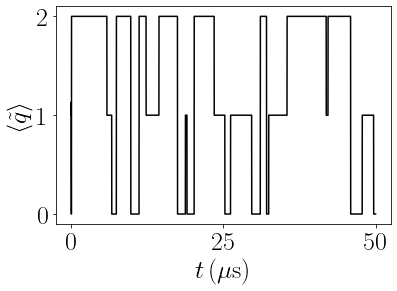

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$t\, (\mu{\rm s})$')
ax.set_ylabel(r'$\langle \tilde{q} \rangle$')
ax.set_xticks(np.array([0,Nt*dt/2,Nt*dt]), labels=['$0$','$25$','$50$'])
plt.plot(ttab,qarr,'k')
plt.show()

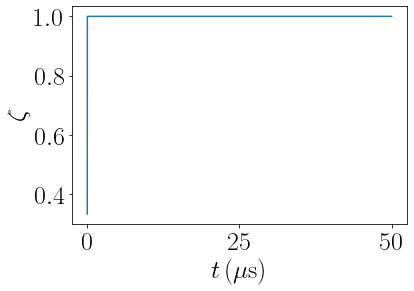

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$t\, (\mu{\rm s})$')
ax.set_ylabel(r'$\zeta$')
ax.set_xticks(np.array([0,Nt*dt/2,Nt*dt]), labels=['$0$','$25$','$50$'])
plt.plot(ttab,IPRarr)
plt.show()

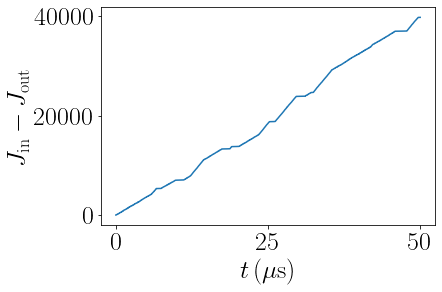

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$t\, (\mu{\rm s})$')
ax.set_ylabel(r'$J_{\rm in}-J_{\rm out}$')
ax.set_xticks(np.array([0,Nt*dt/2,Nt*dt]), labels=['$0$','$25$','$50$'])
plt.plot(ttab,Jdiff)
plt.show()

In [25]:
# Mean values of the current at Vb=2.6 found from code "Sec2_ReadoutDynamics2PF"
I0=4.476
I1=237.1
I2=117.5

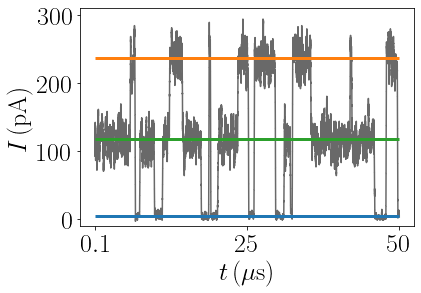

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$t\, (\mu{\rm s})$')
ax.set_ylabel(r'$I\, (\rm pA)$')
ax.set_xticks(np.array([tb,Nt*dt/2,Nt*dt]), labels=['$0.1$','$25$','$50$'])
ax.set_yticks(np.array([0,100,200,300]), labels=['$0$','$100$','$200$','$300$'])
ttabcurr=np.linspace(Navg*dt,Nt*dt,Nt-Navg)
ax.plot(ttabcurr,Itab,color='dimgrey')
ax.hlines(I0,tb,Nt*dt,color='tab:blue',linewidth=3)
ax.hlines(I1,tb,Nt*dt,color='tab:orange',linewidth=3)
ax.hlines(I2,tb,Nt*dt,color='tab:green',linewidth=3)
plt.ylim(ymin=-10,ymax=310)
plt.show()